In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from model.regression import *

In [3]:
audio_file = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav'
labels_file = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt'

device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

trn_dataset = VehicleDataset(audio_file, labels_file, start_time=1*60, end_time=25*60, use_offset=True)

all: 246 | positive: 143


In [4]:
loader = DataLoader(trn_dataset, batch_size=5)

In [5]:
x, y = next(iter(loader))

In [6]:
x.shape

torch.Size([5, 1, 72, 1034])

In [7]:
model = ResNet18().to(device)

In [8]:
n_frames = 3

X = x.split(x.shape[3] // n_frames + 1, dim=3)

In [9]:
len(X)

3

In [26]:
val_dataset = VehicleDataset(audio_file, labels_file, start_time=25 * 60,  seed=0)
val_loader = DataLoader(val_dataset, batch_size=32)

all: 94 | positive: 50


In [27]:
weights = torch.load(f'weights/regression/model_1627300684.pth', device)
model.load_state_dict(weights)

<All keys matched successfully>

In [28]:
val_loss = 0
n_frames = 3

model.eval()
with torch.no_grad():
    for tensor, target in val_loader:
        tensor = tensor.to(device)
        target = target.to(device)

        X = tensor.split(tensor.shape[3] // n_frames + 1, dim=3)

        Y = torch.zeros(tensor.shape[0]).to(device)

        for x in X:
            Y += model(x).squeeze().abs()

        loss_value = (Y - target).abs().sum()

        val_loss += loss_value.detach().item()

In [29]:
val_loss

19.07159185409546

### Test

In [14]:
audio_file = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav'
labels_file = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt'

signal, sr = torchaudio.load(audio_file)
signal = signal.mean(0)

events = np.loadtxt(labels_file)

In [49]:
start_time = 1 * 60
T = 9 * 60

t0 = start_time
t1 = start_time + T
s = signal[t0 * sr: t1 * sr]

results = []

frame_len = 1.0

X = val_dataset.transform(s).unsqueeze(0)
X = X.split(575, dim=3)

model.eval()
with torch.no_grad():
    for x in tqdm(X):
        x = x.to(device)
        y = model(x).abs().item()
        results.append(y)

  0%|          | 0/324 [00:00<?, ?it/s]

<Figure size 4320x432 with 0 Axes>

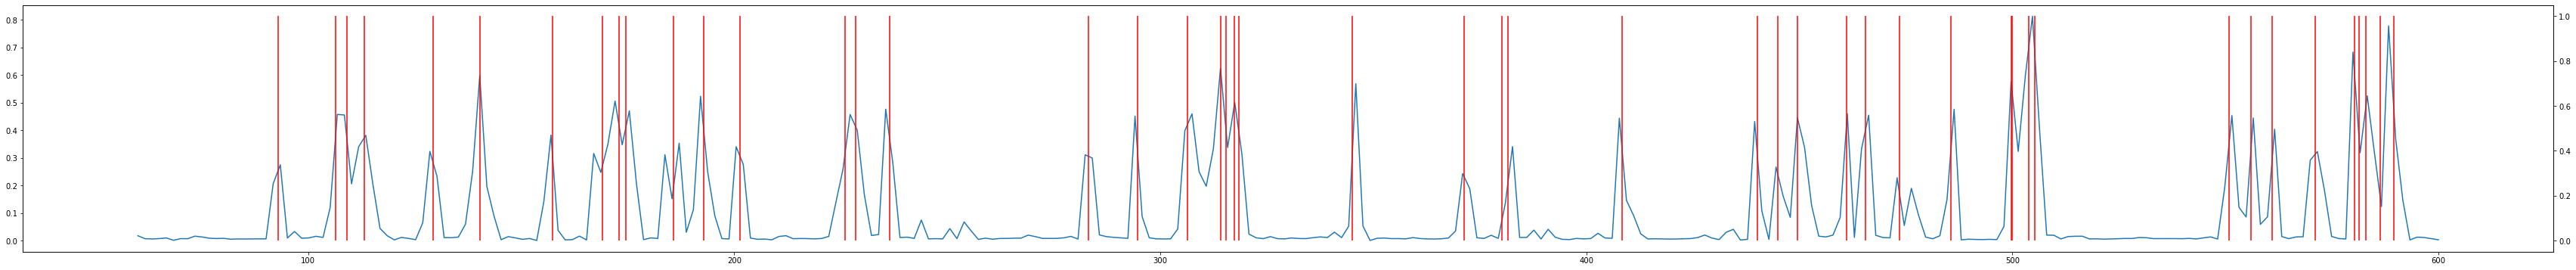

In [50]:
plt.figure(figsize=(60, 6))

fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()

T1 = np.linspace(0, T, len(results)) + start_time
ax1.plot(T1, results)

for event in events[(events >= start_time) & (events < start_time + T)]:
    ax2.vlines(event, 0, 1, color='r')

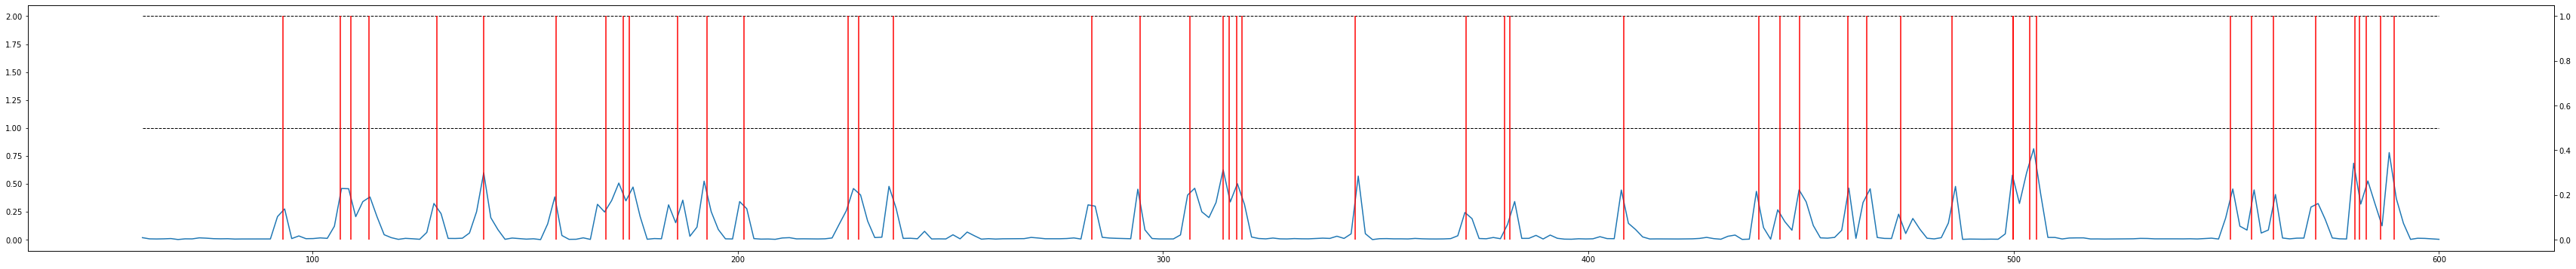

In [51]:
results_convolved = np.convolve(results, np.ones(1), 'valid')
# results_convolved = np.pad(results_convolved, 50, mode='constant', constant_values=1)[:-1]

# plt.plot(results_convolved);
T1 = np.linspace(0, T, len(results_convolved)) + start_time

fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()

ax1.plot(T1, results_convolved)

ax1.hlines(1.0, T1[0], T1[-1], color='black', linestyle='--', linewidth=1.0)
ax1.hlines(2.0, T1[0], T1[-1], color='black', linestyle='--', linewidth=1.0)

for event in events[(events >= start_time) & (events < start_time + T)]:
    ax2.vlines(event, 0, 1, color='r')

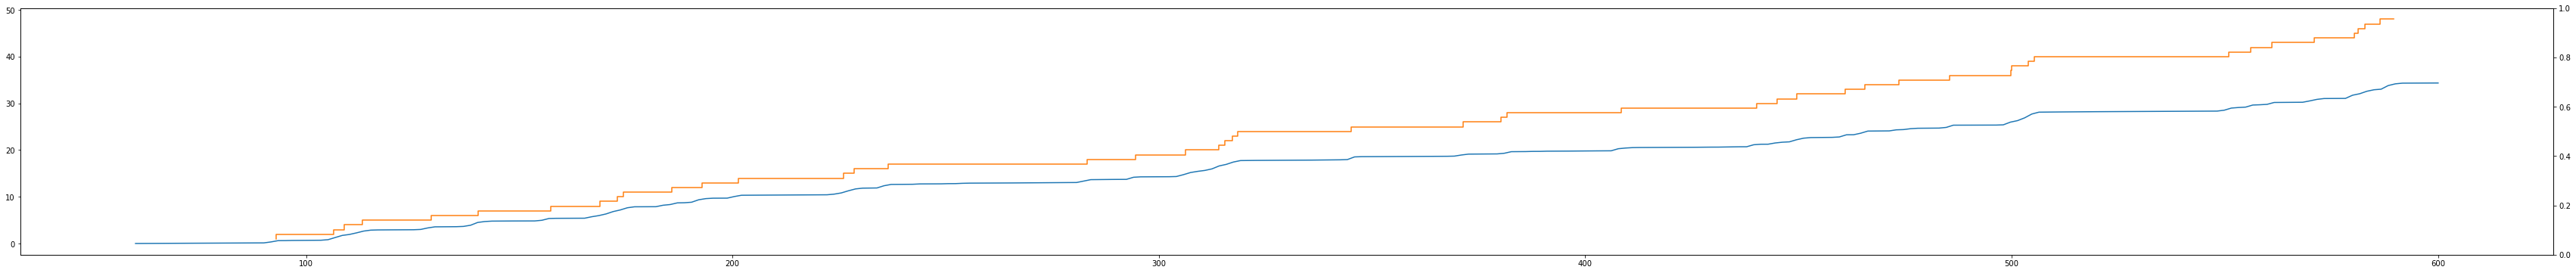

In [54]:
cumsum = np.cumsum(results)

T1 = np.linspace(0, T, len(results_convolved)) + start_time

fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()

ax1.plot(T1, cumsum)

E = events[(events >= start_time) & (events < start_time + T)]

ax1.step(E, (np.arange(1, len(E) + 1)));